<a href="https://colab.research.google.com/github/ovazque/ML/blob/main/Housing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from posix import close
import os
import tarfile
import urllib

DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml2/master/"
HOUSNG_PATH = os.path.join("datasets","housing")
HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing.tgz"

def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSNG_PATH):
  os.makedirs(housing_path, exist_ok=True)
  tgz_path = os.path.join(housing_path, "housing.tgz")
  urllib.request.urlretrieve(housing_url, tgz_path)
  housing_tgz = tarfile.open(tgz_path)
  housing_tgz.extractall(path=housing_path)
  housing_tgz.close()

In [2]:
fetch_housing_data()

In [3]:
import pandas as pd

def load_housing_data(housing_path=HOUSNG_PATH):
  cvs_path = os.path.join(housing_path, "housing.csv")
  return pd.read_csv(cvs_path)

In [4]:
housing = load_housing_data()
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


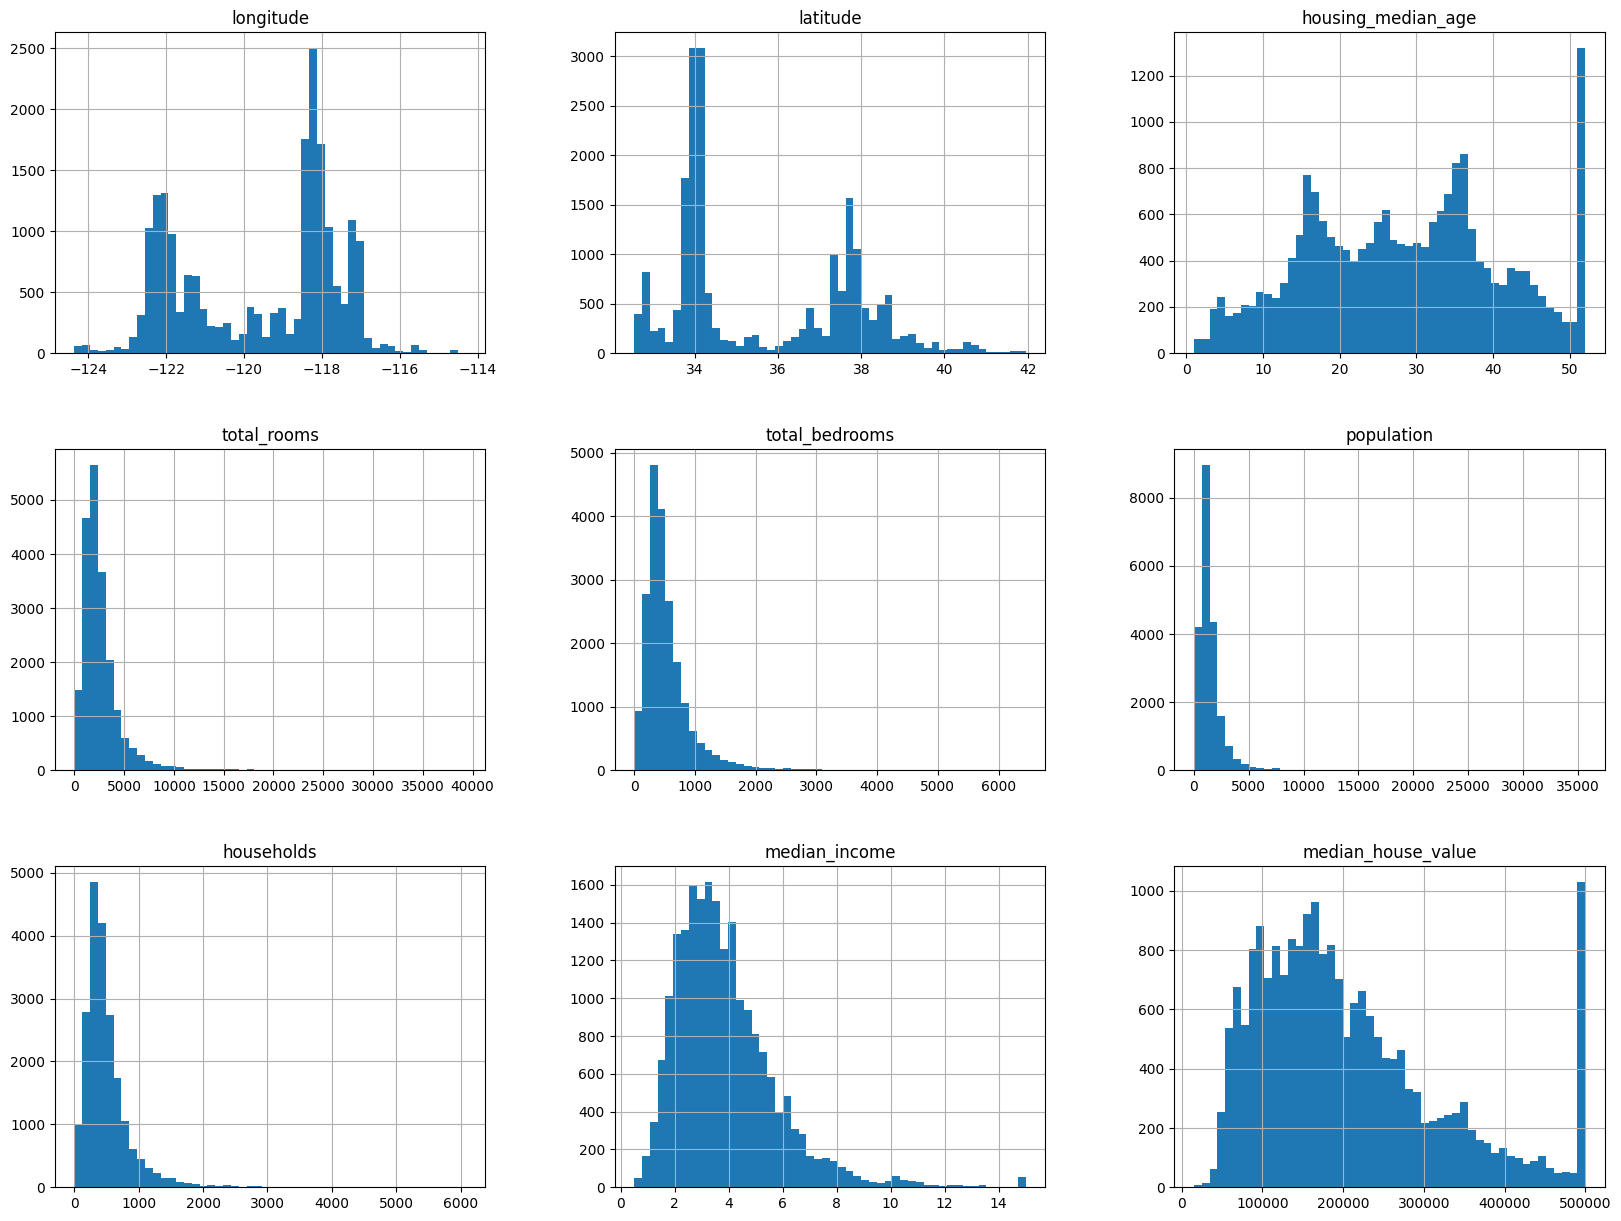

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt
housing.hist(bins=50, figsize=(20,15))
plt.show()

#Creating a Test Set

We need to set aside 20% of the sample for testing. Two approaches using purely random sampling are considered:

1.  The first approach

2.  Use each instance's indentifier to decide whether or not it should go in the test set (assuming instances have a unique and immutable identifier). For example, one could compute a hash of each instance's indentifier and put that instance in the test set if the hash is lower or equal to 20% of the maximum hash value. This is done calling the function ```split_train_test_by_id()```.





In [6]:
import numpy as np
def split_train_test(data, test_ratio):
  np.random.seed(42)
  shuffled_indices = np.random.permutation(len(data))
  test_set_size = int(len(data)*test_ratio)
  test_indices = shuffled_indices[:test_set_size]
  train_indices = shuffled_indices[test_set_size:]
  return data.iloc[train_indices], data.iloc[test_indices]

In [7]:
train_set, test_set = split_train_test(housing,0.2)
print(f'Train set size = {len(train_set)/len(housing)} (%)\nTest set size = {len(test_set)/len(housing)} (%)')

Train set size = 0.8 (%)
Test set size = 0.2 (%)


In [8]:
from zlib import crc32
def test_set_check(identifier, test_ratio):
  return crc32(np.int64(identifier)) & 0xffffffff < test_ratio * 2**32

def split_train_test_by_id(data, test_ratio, id_column):
  ids = data[id_column]
  in_test_set = ids.apply(lambda id_: test_set_check(id_, test_ratio))
  #print(in_test_set)
  return data.loc[~in_test_set], data.loc[in_test_set]

In [9]:
housing_with_id = housing.reset_index()

In [10]:
train_set, test_set = split_train_test_by_id(housing_with_id,0.2,"index")

In [11]:
test_set.head()

,index,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
2,2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
5,5,-122.25,37.85,52.0,919.0,213.0,413.0,193.0,4.0368,269700.0,NEAR BAY
12,12,-122.26,37.85,52.0,2491.0,474.0,1098.0,468.0,3.0750,213500.0,NEAR BAY
16,16,-122.27,37.85,52.0,1966.0,347.0,793.0,331.0,2.7750,152500.0,NEAR BAY
23,23,-122.27,37.84,52.0,1688.0,337.0,853.0,325.0,2.1806,99700.0,NEAR BAY


# Stratified sampling
The code below uses the ```median_income``` attribute to generate a test set using *stratifed sampling*. The idea is that instances with a ```median income``` between 1.5 and 6 should have a larger representation in the test set than instances with a ```median income``` below 1.5 or larger than 6. The stratified sampling approach allows to generate a test set that is representative of the various categories of incomes in the whole dataset.

In [12]:
housing["income_cat"] = pd.cut(housing["median_income"],
                               bins=[0.0, 1.5, 3.0, 4.5, 6.0, 1000],
                               labels=[1,2,3,4,5])

<Axes: >

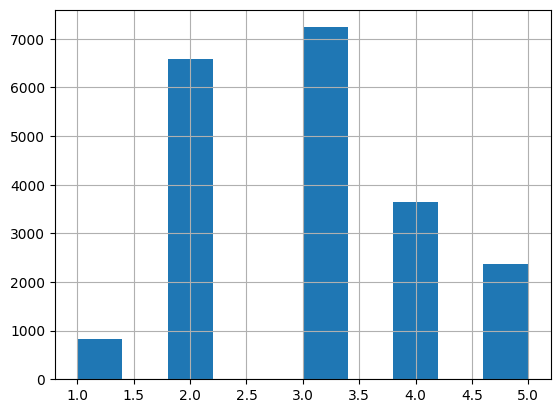

In [13]:
housing["income_cat"].hist()

In [14]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(housing, housing["income_cat"]):
  strat_train_set = housing.loc[train_index]
  strat_test_set = housing.loc[test_index]

The line below shows the income category proportions in the full data set.

In [15]:
housing["income_cat"].value_counts()/len(housing)

3    0.350581
2    0.318847
4    0.176308
5    0.114438
1    0.039826
Name: income_cat, dtype: float64

The line below shows the income category proportions from using *straified sampling*. As expected, these proportions are very similar to the ones from the full data set.

In [16]:
strat_test_set["income_cat"].value_counts()/len(strat_test_set)

3    0.350533
2    0.318798
4    0.176357
5    0.114341
1    0.039971
Name: income_cat, dtype: float64

In [17]:
train_set, test_set = split_train_test(housing,0.2)

The line below shows the income category proportions from using *random sampling*. These proportions are less similar to the ones from the full data set compared when compared with the values obtained from *straified sampling*.

In [23]:
train_set["income_cat"].value_counts()/len(train_set)

3    0.348595
2    0.317466
4    0.178537
5    0.115673
1    0.039729
Name: income_cat, dtype: float64

In [24]:
for set_ in (strat_train_set, strat_test_set):
  set_.drop("income_cat", axis=1, inplace=True)

KeyError: ignored

In [25]:
housing = strat_train_set.copy()

<Axes: xlabel='longitude', ylabel='latitude'>

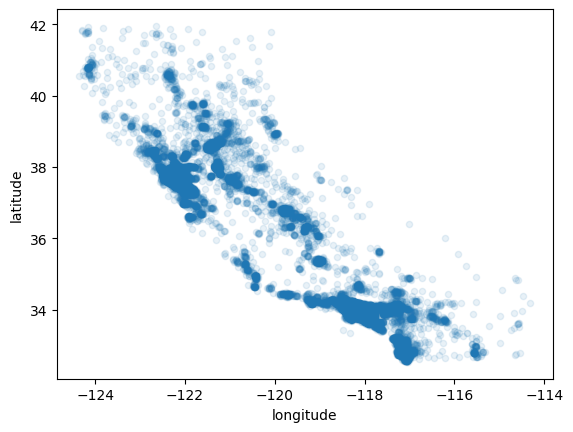

In [26]:
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.1)

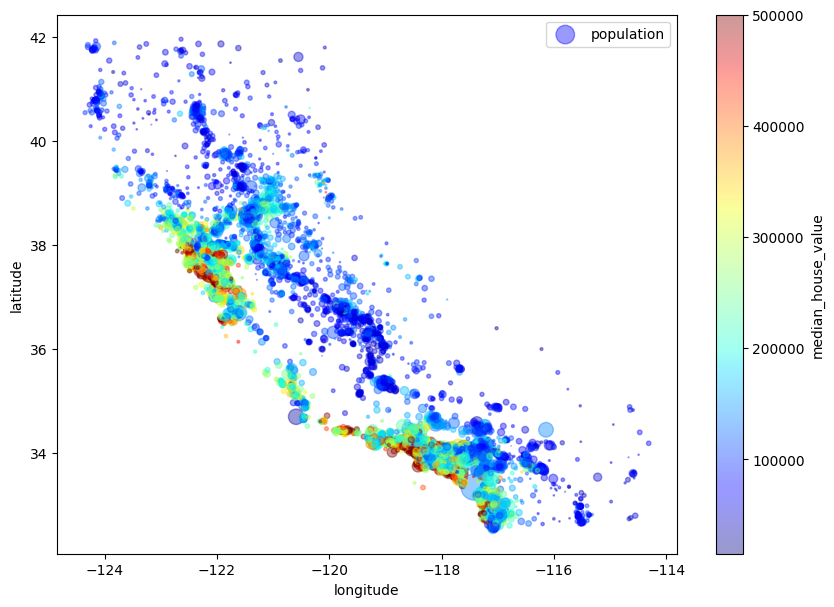

In [27]:
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.4,
             s=housing["population"]/100, label="population", figsize=(10,7),
             c="median_house_value", cmap=plt.get_cmap("jet"),colorbar=True)
plt.legend()

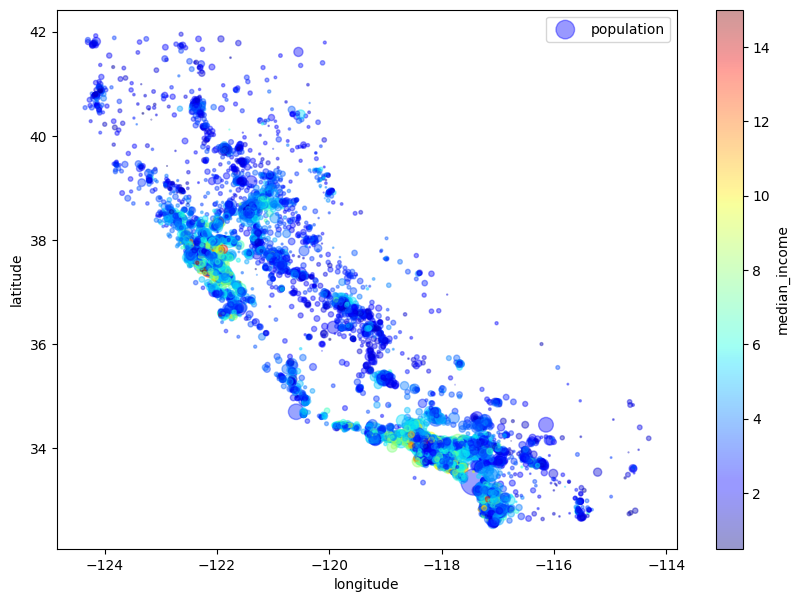

In [44]:
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.4,
             s=housing["population"]/100, label="population", figsize=(10,7),
             c="median_income", cmap=plt.get_cmap("jet"),colorbar=True)
plt.legend()

In [29]:
corr_matrix = housing.corr()

<ipython-input-29-bac487469033>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = housing.corr()


In [30]:
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.687151
total_rooms           0.135140
housing_median_age    0.114146
households            0.064590
total_bedrooms        0.047781
population           -0.026882
longitude            -0.047466
latitude             -0.142673
Name: median_house_value, dtype: float64

array([[<Axes: xlabel='median_house_value', ylabel='median_house_value'>,
        <Axes: xlabel='median_income', ylabel='median_house_value'>,
        <Axes: xlabel='total_rooms', ylabel='median_house_value'>,
        <Axes: xlabel='housing_median_age', ylabel='median_house_value'>],
       [<Axes: xlabel='median_house_value', ylabel='median_income'>,
        <Axes: xlabel='median_income', ylabel='median_income'>,
        <Axes: xlabel='total_rooms', ylabel='median_income'>,
        <Axes: xlabel='housing_median_age', ylabel='median_income'>],
       [<Axes: xlabel='median_house_value', ylabel='total_rooms'>,
        <Axes: xlabel='median_income', ylabel='total_rooms'>,
        <Axes: xlabel='total_rooms', ylabel='total_rooms'>,
        <Axes: xlabel='housing_median_age', ylabel='total_rooms'>],
       [<Axes: xlabel='median_house_value', ylabel='housing_median_age'>,
        <Axes: xlabel='median_income', ylabel='housing_median_age'>,
        <Axes: xlabel='total_rooms', ylabel='housi

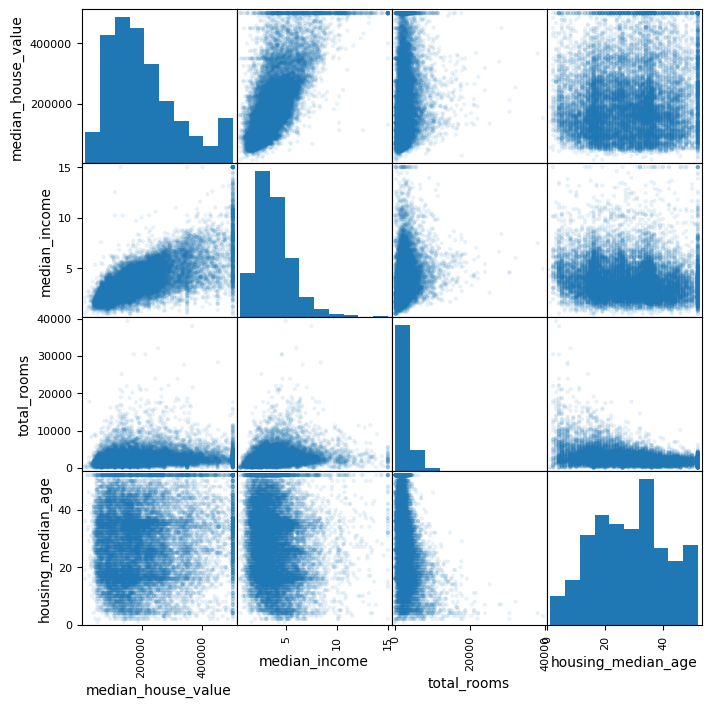

In [31]:
from pandas.plotting import scatter_matrix

attributes = ["median_house_value","median_income","total_rooms","housing_median_age"]
scatter_matrix(housing[attributes],alpha=0.1,figsize=[8,8],diagonal="hist")

There seems to be a positive linear correlation between the ```median_house_value``` and the ```median_income```. Let's magnify this correlation.

<Axes: xlabel='median_income', ylabel='median_house_value'>

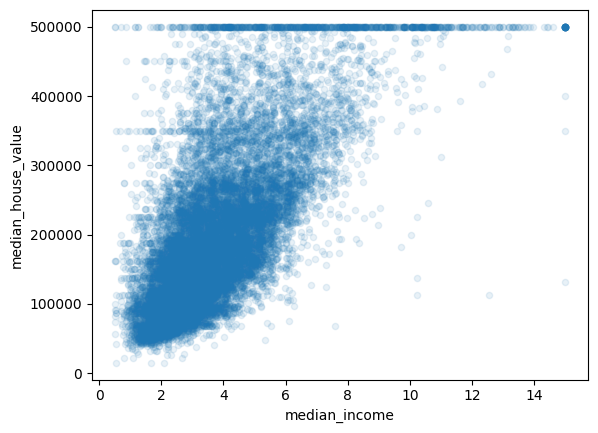

In [32]:
housing.plot(kind="scatter", x="median_income", y="median_house_value",alpha=0.1)

New attributes: ```rooms_per_household```, ```bedrooms_per_room``` and ```population_per_household``` are derived from the original set of attribues. These new imput variables might be more helpful when feeding the ML algorithm than using for example the total ```total_rooms``` or ```total_bedrooms```.

In [37]:
housing["rooms_per_household"] = housing["total_rooms"]/housing["households"]
housing["bedrooms_per_room"] = housing["total_bedrooms"]/housing["total_rooms"]
housing["population_per_household"] = housing["population"]/housing["households"]

The correlation between the derived atributes and the ```median_house_value``` attribute are shown below.
*   There in an anticorrelation between ```median_house_value``` and ```bedrooms_per_room```. On average expensive houses tend to have small bedrroms/room ratio.




array([[<Axes: xlabel='median_house_value', ylabel='median_house_value'>,
        <Axes: xlabel='median_income', ylabel='median_house_value'>,
        <Axes: xlabel='rooms_per_household', ylabel='median_house_value'>,
        <Axes: xlabel='bedrooms_per_room', ylabel='median_house_value'>],
       [<Axes: xlabel='median_house_value', ylabel='median_income'>,
        <Axes: xlabel='median_income', ylabel='median_income'>,
        <Axes: xlabel='rooms_per_household', ylabel='median_income'>,
        <Axes: xlabel='bedrooms_per_room', ylabel='median_income'>],
       [<Axes: xlabel='median_house_value', ylabel='rooms_per_household'>,
        <Axes: xlabel='median_income', ylabel='rooms_per_household'>,
        <Axes: xlabel='rooms_per_household', ylabel='rooms_per_household'>,
        <Axes: xlabel='bedrooms_per_room', ylabel='rooms_per_household'>],
       [<Axes: xlabel='median_house_value', ylabel='bedrooms_per_room'>,
        <Axes: xlabel='median_income', ylabel='bedrooms_per_room'>,

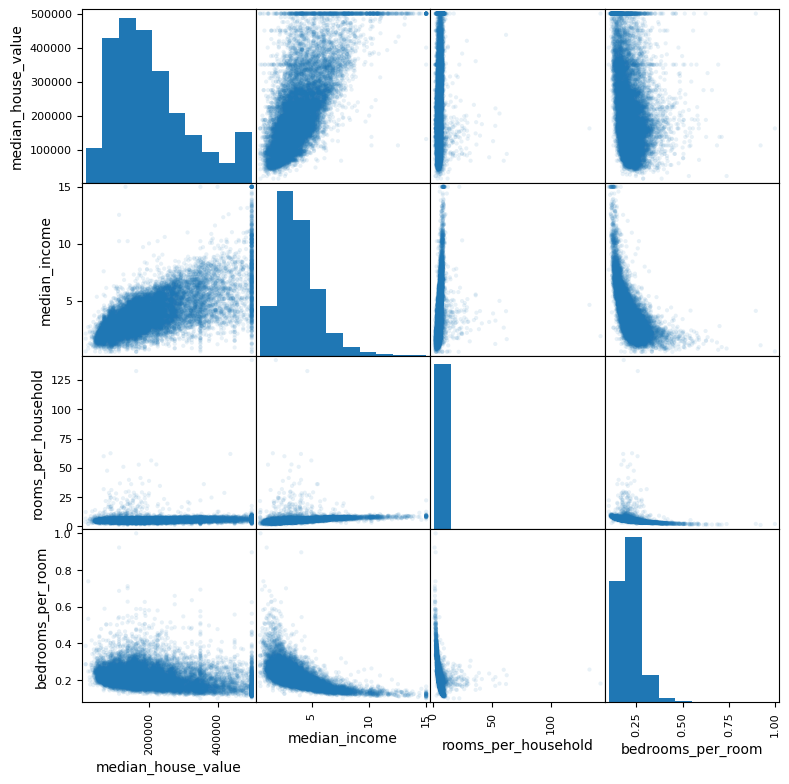

In [69]:
extended_attributes = ["median_house_value","median_income","rooms_per_household","bedrooms_per_room"]
scatter_matrix(housing[extended_attributes],alpha=0.1,figsize=[9,9],diagonal="hist")

In [42]:
corr_matrix = housing.corr()
corr_matrix["median_house_value"].sort_values(ascending=False)

<ipython-input-42-51a0e6bf2eb4>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = housing.corr()


median_house_value          1.000000
median_income               0.687151
rooms_per_household         0.146255
total_rooms                 0.135140
housing_median_age          0.114146
households                  0.064590
total_bedrooms              0.047781
population_per_household   -0.021991
population                 -0.026882
longitude                  -0.047466
latitude                   -0.142673
bedrooms_per_room          -0.259952
Name: median_house_value, dtype: float64

# Prepare the data fro ML algorithms

In [93]:
housing = strat_train_set.drop("median_house_value",axis=1)

In [95]:
housing_labels = strat_train_set["median_house_value"].copy()

In [100]:
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy="median")

In [101]:
housing_num = housing.drop("ocean_proximity",axis=1)

In [102]:
# Computes the attributes' median values
# the NaN are omitted from the median calculation
imputer.fit(housing_num)

SimpleImputer(strategy='median')

In [105]:
# The attributes' median values are stored in the "statistics_" instance variable
# statistics_ belongs to the instance variable "imputer" (from the SimpleImputer class)
imputer.statistics_

array([-118.51   ,   34.26   ,   29.     , 2119.     ,  433.     ,
       1164.     ,  408.     ,    3.54155])

In [127]:
# Computes the attributes' median values from the data frame "housing_num"
# Setting skipna=True excludes the NaN features from the median computation
housing_num.median(axis=0,skipna=True)

longitude             -118.51000
latitude                34.26000
housing_median_age      29.00000
total_rooms           2119.00000
total_bedrooms         433.00000
population            1164.00000
households             408.00000
median_income            3.54155
dtype: float64

In [130]:
# This returns a numpy array X of shape [nrows,ncolumns]
# The numpy array contains all the features from the different attributes.
# The NaN features are replaced by the attribute's median.
X = imputer.transform(housing_num)

In [131]:
# Comfirm the attributes' median
np.median(X,axis=0)

array([-118.51   ,   34.26   ,   29.     , 2119.     ,  433.     ,
       1164.     ,  408.     ,    3.54155])

In [133]:
# Let's put the transformed features into a pandas DataFrame
housing_tr = pd.DataFrame(X, columns=housing_num.columns, index=housing_num.index)

In [136]:
housing_tr.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16512 entries, 12655 to 19773
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           16512 non-null  float64
 1   latitude            16512 non-null  float64
 2   housing_median_age  16512 non-null  float64
 3   total_rooms         16512 non-null  float64
 4   total_bedrooms      16512 non-null  float64
 5   population          16512 non-null  float64
 6   households          16512 non-null  float64
 7   median_income       16512 non-null  float64
dtypes: float64(8)
memory usage: 1.1 MB
